In [ ]:
/content/drive/MyDrive/Colab Notebooks/result

In [3]:
!pip install paddlepaddle
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=4cd3ec24b4110bbb7387cbe7a6c2228ebbc2eb9b10a88646b77d247e9958841a
  Stored in di

# 학습 모델

In [4]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import unicodedata
from tensorflow.keras.models import load_model


In [5]:
# 데이터 전처리 함수
def extract_info_from_filename(filename):
    base_name = os.path.basename(filename)
    name_part = base_name.split('.png')[0]
    parts = name_part.split('_')
    if len(parts) < 3:
        return None, None, None
    text = parts[2]
    font = '_'.join(parts[3:])
    return text, font

def load_images_and_labels(image_dir):
    """이미지와 라벨 로드"""
    images = []
    labels = []

    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            img_path = os.path.join(image_dir, file)
            text, font = extract_info_from_filename(file)
            if text and font:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # 이미지 크기 조정
                img = img / 255.0  # 정규화
                images.append(img)
                labels.append((text, font))

    return np.array(images), labels

class PairGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        pairs, pair_labels = self.create_pairs(batch_images, batch_labels)

        # Convert to TensorFlow tensors
        pair_0 = tf.convert_to_tensor(pairs[:, 0], dtype=tf.float32)
        pair_1 = tf.convert_to_tensor(pairs[:, 1], dtype=tf.float32)
        pair_labels = tf.convert_to_tensor(pair_labels, dtype=tf.float32)

        return [pair_0, pair_1], pair_labels

    def create_pairs(self, images, labels):
        pairs = []
        pair_labels = []

        # 같은 클래스 쌍 생성
        label_to_images = {}
        for img, (text, font) in zip(images, labels):
            if text not in label_to_images:
                label_to_images[text] = []
            label_to_images[text].append(img)

        for img_list in label_to_images.values():
            num_images = len(img_list)
            for i in range(num_images):
                for j in range(i + 1, num_images):
                    pairs.append([img_list[i], img_list[j]])
                    pair_labels.append(1)  # 같은 클래스

        # 다른 클래스 쌍 생성
        all_texts = list(label_to_images.keys())
        num_texts = len(all_texts)
        for i in range(num_texts):
            for j in range(i + 1, num_texts):
                img_list1 = label_to_images[all_texts[i]]
                img_list2 = label_to_images[all_texts[j]]
                for img1 in img_list1:
                    for img2 in img_list2:
                        pairs.append([img1, img2])
                        pair_labels.append(0)  # 다른 클래스

        # Convert to NumPy arrays
        return np.array(pairs), np.array(pair_labels)


# Siamese 네트워크 모델 정의
def build_siamese_model(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (10, 10), activation='relu')(input)  # 필터 수 감소
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)  # Dense 레이어 유닛 수 감소
    x = Dense(1, activation='sigmoid')(x)  # Sigmoid 활성화 함수 사용

    return Model(input, x)


def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(margin=1):
    def loss(y_true, y_pred):
        return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
    return loss


# 데이터 로드 및 전처리
image_dir = '/content/drive/MyDrive/Colab Notebooks/result'
images, labels = load_images_and_labels(image_dir)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 데이터 쌍 생성
train_gen = PairGenerator(X_train, y_train, batch_size=8)  # 배치 크기 줄이기
test_gen = PairGenerator(X_test, y_test, batch_size=8)  # 배치 크기 줄이기

# 모델 정의
input_shape = (224, 224, 3)
base_network = build_siamese_model(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.compile(optimizer='adam', loss=contrastive_loss(margin=1))

# --------------------
# `pair_generator` 함수 정의
import tensorflow as tf

# 학습 데이터를 위한 생성기 정의
def pair_generator():
    for pair_batch, label_batch in train_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 유효성 검사 데이터를 위한 생성기 정의
def validation_generator():
    for pair_batch, label_batch in test_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 학습 데이터셋을 위한 output_signature 정의
train_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 학습 데이터셋 생성
train_dataset = tf.data.Dataset.from_generator(
    pair_generator,
    output_signature=train_output_signature
)

# 유효성 검사 데이터셋을 위한 output_signature 정의
validation_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 유효성 검사 데이터셋 생성
validation_dataset = tf.data.Dataset.from_generator(
    validation_generator,
    output_signature=validation_output_signature
)

# steps_per_epoch 값을 데이터셋 크기에 따라 명확히 설정
steps_per_epoch = len(train_gen)

# 모델 학습
model.fit(train_dataset, epochs=10, validation_data=validation_dataset, steps_per_epoch=steps_per_epoch, callbacks=[tf.keras.callbacks.ProgbarLogger()])

# # 모델 훈련
# model.fit(train_gen, epochs=10, validation_data=test_gen)

# 테스트 데이터를 위한 생성기 정의
def test_generator():
    for pair_batch, label_batch in test_gen:
        yield (pair_batch[0], pair_batch[1]), label_batch

# 테스트 데이터셋을 위한 output_signature 정의
test_output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# 테스트 데이터셋 생성
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=test_output_signature
)

# 평가 함수 정의
def evaluate_model(model, test_dataset):
    # 모델 평가
    test_loss = model.evaluate(test_dataset)
    return test_loss

# 모델 평가
test_loss = evaluate_model(model, test_dataset)
print("Test loss:", test_loss)

# 모델 저장
model.save('/content/drive/MyDrive/Colab Notebooks/model/my_siamese_model.h5')

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.8779

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 183s 9s/step - loss: 0.8791 - val_loss: 0.9522
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - loss: 0.0000e+00 - val_loss: 0.9522
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - loss: 0.9042 - val_loss: 0.9522
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - loss: 0.0000e+00 - val_loss: 0.9522
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - loss: 0.9042 - val_loss: 0.9522
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - loss: 0.0000e+00 - val_loss: 0.9522
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - loss: 0.9042 - val_loss: 0.9522
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - loss: 0.0000e+00 - val_loss: 0.9522
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 150s 8s/step - loss: 0.9042 - val_loss: 0.9522
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 544ms/step - loss: 0.0000e+00 - val_loss: 0.9522
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.9519


Test loss: 0.9521535038948059


# 모델 테스트 : 두 이미지 간 유사도 계산

In [6]:
# 모델 사용: 두 이미지 간의 유사도 계산
def calculate_similarity(model, img1, img2):
    img1 = np.expand_dims(img1, axis=0)  # 배치 차원 추가
    img2 = np.expand_dims(img2, axis=0)
    distance = model.predict([img1, img2])
    return distance[0][0]

# 예시 이미지로 유사도 계산
test_image1_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04358_crop_0_6rCR64-Z.png'
test_image2_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04372_crop_0_7LC97KeE64-Z.png'

# 이미지를 불러와서 전처리
test_image1 = cv2.imread(test_image1_path)
test_image2 = cv2.imread(test_image2_path)
test_image1 = cv2.resize(test_image1, (224, 224)) / 255.0
test_image2 = cv2.resize(test_image2, (224, 224)) / 255.0

# 유사도 계산
similarity = calculate_similarity(model, test_image1, test_image2)
print("Similarity score:", similarity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Similarity score: 0.00031622776


In [8]:
# 성능평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 및 정확도 계산 함수 정의

def evaluate_model_performance(model, test_gen, threshold=0.5):
    y_true = []
    y_pred = []

    for i in range(len(test_gen)):
        (pair_0, pair_1), labels = test_gen[i]
        predictions = model.predict([pair_0, pair_1])

        y_true.extend(labels)

        # 임계값을 조정하여 예측 결과를 이진 분류로 변환
        y_pred.extend((predictions > threshold).astype(int))

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# 임계값을 변경하여 성능 평가
thresholds = [0.3, 0.5, 0.7]
for thresh in thresholds:
    accuracy, precision, recall, f1 = evaluate_model_performance(model, test_gen, threshold=thresh)
    print(f"Threshold: {thresh}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
Threshold: 0.3
Accuracy: 0.9528, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
Threshold: 0.5
Accuracy: 0.9528, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
Threshold: 0.7
Accuracy: 0.9528, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 제일 비슷한 손글씨 찾기

import pandas as pd
import numpy as np
import os
import json
import pprint

import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import base64


In [74]:
# 제일 비슷한 손글씨 찾기

# 1. 크롭한 손글씨 이미지, 텍스트 가져오기

# 손글씨 이미지 파일명에서 Base64로 인코딩된 텍스트 추출
def extract_text_from_handwritten_image_filename(filename):
    base_name = os.path.basename(filename)
    name_part = base_name.split('.png')[0]

    # 파일명에서 Base64로 인코딩된 텍스트 부분 추출
    base64_text = name_part.split('_')[-1]  # 마지막 부분이 Base64 텍스트라고 가정

    # Base64 텍스트의 길이를 4의 배수로 맞추기 위해 패딩 추가
    try:
        base64_text += '=' * (-len(base64_text) % 4)
        decoded_text = base64.b64decode(base64_text).decode('utf-8')
        return decoded_text
    except Exception as e:
        print(f"Error decoding Base64 text: {e}")
        return None

In [85]:
handwritten_image_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04358_crop_2_7LKc7LCo7Iqk.png'
test=os.path.basename(handwritten_image_path).replace('.png','').split('_')[-1]
# base64.b64decode(test+'===').decode('utf-8')
# extract_text_from_handwritten_image_filename(handwritten_image_path)
test
test += '=' * (-len(test) % 4)
base64.b64decode(test).decode('utf-8')


'천차스'

In [73]:
# 테스트
handwritten_image_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04367_crop_1_7Iug7Jqp64-Z.png'
test = os.path.basename(handwritten_image_path).split('.png')[0].split('_')[-1]
decoded_text = extract_text_from_handwritten_image_filename(handwritten_image_path)
print(f"Decoded text: {decoded_text}")

Error decoding Base64 text: Incorrect padding
Decoded text: None


In [21]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

In [91]:
## 텍스트 이미지와 동일한 폰트 이미지 생성 및 저장

def txt2image(path, fontName, draw_text):
    try:
        font = ImageFont.truetype(path, 25)
    except IOError:
        print(f"Failed to load font from {path}")
        return

    bbox = font.getbbox(draw_text)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] # gpt bbox[3] -> bbox[3]-bbox[1]
    # 이미지 사이즈 지정
    canvas_width = int(text_width * 1.1)
    canvas_height = int(text_height * 1.2)

    # 이미지 객체 생성 (배경 흰색)
    canvas = Image.new('RGB', (canvas_width, canvas_height), "white")

    draw = ImageDraw.Draw(canvas)
    text_x = (canvas_width - text_width) / 2
    text_y = (canvas_height - text_height) / 3
    draw.text((text_x, text_y), draw_text, 'black', font)

    save_directory = 'drive/MyDrive/Colab Notebooks/data/result2/'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    file_name = f'{save_directory}{draw_text}_{fontName}.png'
    canvas.save(file_name, "PNG")
    print(f'Image saved at {file_name}')

def font2image(draw_text):
    path = '/content/drive/MyDrive/Colab Notebooks/data/font/'
    # fonts_path_list = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.ttf')] #GPT 추천
    fonts_path_list = list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.ttf'), os.listdir(path))))

    print('적용 폰트 종류와 그 갯수:', len(fonts_path_list))

    for font_path in fonts_path_list:
        font_name = font_path.split('/')[-1].replace('.ttf', '')  # 파일 경로에서 폰트 이름 추출
        # print('\t', font_name)
        txt2image(font_path, font_name, draw_text)

    # print('\n변환 단어:', draw_text)



In [92]:
handwritten_image_path = '/content/IMG_OCR_53_4PR_04358_crop_1_7ZWR7ZSE.png'
target_text = extract_text_from_handwritten_image_filename(handwritten_image_path)

if target_text:
    font2image(target_text)
else:
    print("Target text could not be extracted from the handwritten image filename.")


fonts_list = list(map(lambda x:str(x), filter(lambda x: x.endswith('.ttf'), os.listdir(path))))

if len(fonts_path_list) == len(fonts_list):
    print('font 갯수: {}'.format(len(fonts_list)))
    print('폰트 경로 예시: {}'.format(fonts_path_list[0]))
    print('폰트 이름 예시: {}'.format(fonts_list[0]))

적용 폰트 종류와 그 갯수: 19
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_HakgyoansimGaeulsopungL.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_EF_Diary(ttf).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_CHOGOONCHICKENSCRATCHV5-Regular.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_인천교육자람.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_온글잎 윤우체.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_태_흘림L.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_MYHaemalgeunSangsang.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_ROEHOE-CHAN.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_KCCPakKyongni(Windows용).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_THEFACESHOP+INKLIPQUID(윈도우용).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/핑프_YEONGJUSeonbi.png
Image saved at drive/MyDrive/Colab Noteboo

In [35]:
path = '/content/drive/MyDrive/Colab Notebooks/data/font/'

fonts_path_list=list(map(lambda x: path + str(x), filter(lambda x: x.endswith('.ttf'), os.listdir(path))))
[os.path.join(path, f) for f in os.listdir(path) if f.endswith('.ttf')]
os.path.basename(fonts_path_list[0])
# fonts_path_list[0]

'HakgyoansimGaeulsopungL.ttf'

In [61]:
def load_images_and_labels(image_dir, target_size=(224, 224)):
    images = []
    labels = []
    for file_name in os.listdir(image_dir):
        if file_name.endswith('.png'):
            base_name = os.path.basename(file_name)
            name_part = base_name.split('.png')[0]
            text = name_part.split('_')[0]
            font = '_'.join(name.split('_')[1:])


            # 이미지 파일 로드
            image_path = os.path.join(image_dir, file_name)
            image = cv2.imread(image_path)
            if image is not None:
                # 이미지 크기 조정
                image = cv2.resize(image, target_size)
                image = image / 255.0  # 정규화
                images.append(image)
                labels.append((text, font))
            else:
                print(f"Error loading image {image_path}")

    return np.array(images), labels

In [60]:
image_dir = '/content/result2'

name=os.path.basename(os.listdir(image_dir)[0]).replace('.png','')
text=name.split('_')[0]
'_'.join(name.split('_')[1:])
# name.split('_')

os.path.join(image_dir,os.listdir(image_dir)[0])

'/content/result2/핑프_EF_Diary(ttf).png'

In [46]:
# 유사도 계산 및 가장 높은 유사도 이미지 검색
def calculate_similarity(model, img1, img2):
    img1 = np.expand_dims(img1, axis=0)  # 배치 차원 추가
    img2 = np.expand_dims(img2, axis=0)
    distance = model.predict([img1, img2])
    return distance[0][0]

def find_most_similar_font_image(handwritten_image, font_images, model):
    highest_similarity = -1
    most_similar_image = None

    for font_image in font_images:
        similarity = calculate_similarity(model, handwritten_image, font_image)
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_image = font_image

    return most_similar_image, highest_similarity

In [62]:
# 전체 프로세스 ...?
# 가져온 이미지에서 target_text 를 가지고 오는 함수가 추가되어야 함. > 추가 완
def find_best_matching_font_image(handwritten_image, save_path, model):
    target_text = extract_text_from_handwritten_image_filename(handwritten_image_path)
    font2image(target_text)

    filtered_images, filtered_labels = load_images_and_labels(save_path)

    if len(filtered_images) == 0:
        print("No matching font images found for the given text.")
        return None, None, None

    most_similar_image = None
    highest_similarity = -1
    most_similar_label = None

    for img, label in zip(filtered_images, filtered_labels):
        similarity = calculate_similarity(model, handwritten_image, img)
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_image = img
            most_similar_label = label

    return most_similar_image, most_similar_label, highest_similarity


적용 폰트 종류와 그 갯수: 19
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_HakgyoansimGaeulsopungL.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_EF_Diary(ttf).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_CHOGOONCHICKENSCRATCHV5-Regular.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_인천교육자람.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_온글잎 윤우체.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_태_흘림L.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_MYHaemalgeunSangsang.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_ROEHOE-CHAN.png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_KCCPakKyongni(Windows용).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_THEFACESHOP+INKLIPQUID(윈도우용).png
Image saved at drive/MyDrive/Colab Notebooks/data/result2/마상_YEONGJUSeonbi.png
Image saved at drive/MyDrive/Colab Noteboo

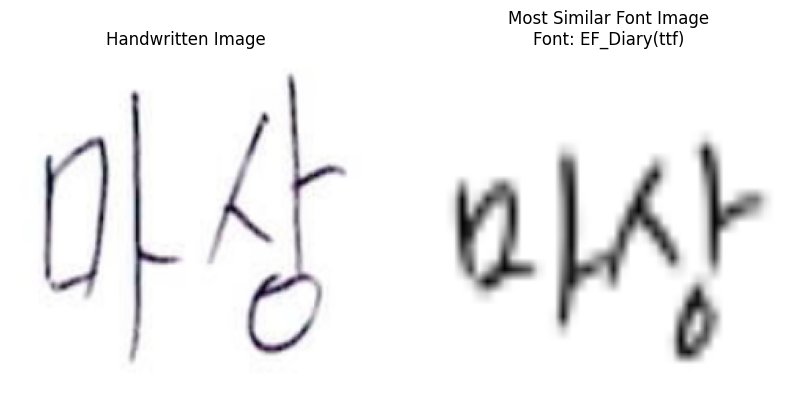

모든 파일이 삭제되었습니다.


In [101]:
# 손글씨 이미지 로드 및 전처리
# 손글씨 이미지 로드 및 전처리
handwritten_image_path = '/content/drive/MyDrive/Colab Notebooks/cropped_images/IMG_OCR_53_4PR_04425_crop_8_66eI7IOB.png'
handwritten_image = cv2.imread(handwritten_image_path)
handwritten_image = cv2.resize(handwritten_image, (224, 224)) / 255.0
save_path = '/content/drive/MyDrive/Colab Notebooks/data/result2'


# 가장 유사한 폰트 이미지 찾기
most_similar_image, most_similar_label, similarity_score = find_best_matching_font_image(handwritten_image, save_path, model)

if most_similar_image is not None:
    print(f"Most similar font image found with similarity score: {similarity_score}")
    print(f"Font name: {most_similar_label[1]}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Handwritten Image')
    plt.imshow(handwritten_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Most Similar Font Image\nFont: {most_similar_label[1]}')
    plt.imshow(most_similar_image, cmap='gray')
    plt.axis('off')

    plt.show()
else:
    print("No similar font image found.")


# 새로 돌리기 전 폴더 내용물 삭제
import os
import glob


# 해당 폴더 내의 모든 파일 경로를 가져옴
files = glob.glob(os.path.join(save_path, "*"))

# 각 파일을 삭제
for file in files:
    if os.path.isfile(file):  # 파일인 경우만 삭제
        os.remove(file)

print("모든 파일이 삭제되었습니다.")

In [94]:
# 새로 돌리기 전 폴더 내용물 삭제
import os
import glob


# 해당 폴더 내의 모든 파일 경로를 가져옴
files = glob.glob(os.path.join(save_path, "*"))

# 각 파일을 삭제
for file in files:
    if os.path.isfile(file):  # 파일인 경우만 삭제
        os.remove(file)

print("모든 파일이 삭제되었습니다.")

모든 파일이 삭제되었습니다.


In [95]:
files = glob.glob(os.path.join(save_path, "*"))